In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from jax import random
from types import SimpleNamespace
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
import flax
from flax.core import FrozenDict

print("Flax version:", flax.__version__)

Flax version: 0.12.1


In [4]:
for dev in jax.devices(): print(dev)

try: # choose gpu if avaliable
    device = jax.devices('gpu')[0]
except: # otherwise default to cpu
    device = jax.devices('cpu')[0]

device

TFRT_CPU_0


CpuDevice(id=0)

## 1. The Buffer-Stock Model

$$
v_t(m_t,p_t) = \max_{a_t} u(c_t)+\beta E_t[v_{t+1}(m_{t+1},p_{t+1})] \\
\text{s.t.} \\
c_t = (1-a_t)m_t \\
m_{t+1} = (1+r)(m_t-c_t) + \text{income}_{t+1} \\
\text{income}_{t+1} = \kappa_{t+1} \psi_{t+1}p_{t+1} \\
p_{t+1} = \xi_{t+1}p_t^{\rho} \\
a_t \in [0,1]
$$

$a_t$ = $\pi(s_t)$ is approximated with neural network $\pi(s_t) \approx \pi^{DNN}(t,s_t;\theta_\pi)$

## 1. Create neural network using FLAX

In [5]:
class Policy(nnx.Module):

  # layers should be flax compatible list: syntax for parameter updates in list
  layers: list[nnx.Linear]
  
  def __init__(self, din: int, dout: int, neurons: list, rngs: nnx.Rngs):

    # 1. initialize
    layers = []

    # 2. 1st layer
    layers.append(nnx.Linear(din, neurons[0], rngs=rngs))
    
    # 3. hidden layers
    for layer in range(len(neurons)-1):
      
      layers.append(nnx.Linear(neurons[layer], neurons[layer+1], rngs=rngs))

    # 4. output layer
    layers.append(nnx.Linear(neurons[-1], dout, rngs=rngs))

    # 5. assign to neural network
    self.layers = nnx.List(layers)

  def __call__(self, x: jax.Array):

    # 1. 1st and hiden layers
    for layer in self.layers[:-1]:

      x = nnx.relu(layer(x)) # ReLU activation for input and all hidden layers

    # 2. output layer
    layer = self.layers[-1] 
    y = jax.nn.sigmoid(layer(x)) # sigmoid activation for output layer

    return y

We could include time as a continuous input in the network, i.e. $\pi(s_t) \approx \pi^{DNN}(0,s_t;\theta_\pi)$ for evaluating the policy in $t=0$. However, in our experience, it is better handled as time dummies: $\pi(s_t) \approx \pi^{DNN}((1,0,0,\dots),s_t;\theta_\pi)$ for $t=0$.

Implementing time dummies implies that we have to add $T$ extra inputs to the neural network and construct a wrapper function that easily makes time dummies, combines them with states, passes everything to the neural network and returns actions.

In [6]:
def setup_nn(model):
  """
  Function that takes economic model object and returns suitable neural network
  """

  par = model.par
  train = model.train

  # 1. unpack
  T = par.get("T")
  Nstates = par.get("Nstates")
  Nactions = par.get("Nactions")

  # 2. compute in- and output dimensions and retrieve list of neurons
  din = Nstates + T
  dout = Nactions
  neurons = train.get("neurons")

  # 3. call policy class
  nn = Policy(din, dout, neurons, rngs=nnx.Rngs(params=0)) # last kwarg set seed=0 for bias and weight initialization

  return nn

def eval_policy(nn,x,t):
  """
  Function that takes neural network, states and the time period and transforms time input to dummy variables and passes everything to neural network
  """

  # 1. infer attributes of states
  Nx = x.shape[0]
  Nstates = x.shape[1]

  # 2. infer total number of time periods from network structure
  T = nn.layers[0].in_features - Nstates

  # 3. construct time dummies and concat with states x
  time_dummies = jax.nn.one_hot(t, T) # shape (T,)
  time_dummies = jnp.broadcast_to(time_dummies, (Nx, T))
  x = jnp.concatenate((x,time_dummies),axis=-1)
  
  # 4. pass to network
  action = nn(x)

  return action

### 1.1 Test policy

In [7]:
hidden_layers = [5,5,10] # 5 neurons in input and first hidden layer and 10 in second hidden layer
din = 10 # number of states and time periods
dout = 1 # number of actions

neural_net_test = Policy(din, dout, hidden_layers, rngs=nnx.Rngs(params=0))

In [8]:
# 1. draw random states for 1 individual
x_test = random.normal(random.key(0), shape=(1,din))

neural_net_test(x_test)

Array([[0.5701341]], dtype=float32)

In [9]:
# 1. draw random states for 20 individuals
N = 20
x_test = random.normal(random.key(0), shape=(N,din))

neural_net_test(x_test)

Array([[0.5701341 ],
       [0.562211  ],
       [0.5975553 ],
       [0.65444136],
       [0.72693014],
       [0.5660716 ],
       [0.5       ],
       [0.50856334],
       [0.6697087 ],
       [0.6374486 ],
       [0.6104777 ],
       [0.5677598 ],
       [0.5970321 ],
       [0.5883862 ],
       [0.72699654],
       [0.6646006 ],
       [0.60491925],
       [0.5688924 ],
       [0.56430894],
       [0.5246854 ]], dtype=float32)

## 2. Create (economic) model class

In [10]:
class Model():

    par: dict
    train: dict
    sim: dict
    policy: Policy
    opt: nnx.Optimizer

    def __init__(self, device, **kwargs):

        self.device = device

        par = {}
        train = {}
        sim = {}

        # a. model
        par["T"] = 10                     # number of periods

        # preferences
        par["beta"] = 1/1.01             # discount factor

        # income
        par["kappa_base"] = 1.0
        par["rho_p"] = 0.95              # shock persistence
        par["sigma_xi"] = 0.1            # permanent shock std
        par["sigma_psi"] = 0.1           # transitory shock std

        # return
        par["R"] = 1.01                  # gross return

        # initial states
        par["mu_m0"] = 1.0               # initial cash-on-hand mean
        par["sigma_m0"] = 0.1            # initial cash-on-hand std

        # initial permanent income
        par["mu_p0"] = 1.0               # initial permanent income mean
        par["sigma_p0"] = 0.1            # initial permanent income std

        # b. solver settings
        par["Nstates"] = 2               # number of state variables
        par["Nactions"] = 1              # number of action variables
        par["Nshocks"] = 2               # number of shocks

        # c. simulation 
        sim["N"] = 10_000                # number of agents

        # d. neural network and training
        train["neurons"] = [100, 100]     # number of neurons in hidden layers
        train["N"] = 3000                 # number of agents for training
        train["seed"] = 0                 # random seed
        train["learning_rate_policy"] = 1e-3   # learning rate for policy
        train['K'] = 1000

        # overwrite with specified parameters
        for key, val in kwargs.items():
            if key in par:
                par[key] = val
            elif key in train:
                train[key] = val
            elif key in sim:
                sim[key] = val
                
        self.par = par
        self.train = train
        self.sim = sim
        self.dtype = jnp.float32

### 2.1 Test policy through class

In [11]:
model_test = Model(device, N=1000)
model_nn_test =  setup_nn(model_test)

In [12]:
x_test = random.normal(random.key(0), shape=(1, model_test.par.get("Nstates")))
eval_policy(model_nn_test,x_test,t=1)

Array([[0.60003495]], dtype=float32)

### 2.2 Test jitted policy through class

In [13]:
jax.jit(eval_policy)(model_nn_test,x_test,t=1)

Array([[0.60003495]], dtype=float32)

## 3. Draw before runs (work-around to avoid JAX random keys)

Draw training and test data for all $K$ iterations

In [14]:
def draw_all(par, train, sim):
    
    # 1. set seed
    np.random.seed(train['seed'])

    # 2. unpack
    sigma_m0 = par['sigma_m0']
    sigma_p0 = par['sigma_p0']
    sigma_xi = par['sigma_xi']
    sigma_psi = par['sigma_psi']
    K = train['K']
    T = par['T']
    N = train['N']
    N_sim = sim['N']

    # 3. set global
    global initial_states_train
    global initial_states_test
    global shocks_train
    global shocks_test

    # 4. draw training data
    m0_train = np.exp(np.random.normal(-0.5*sigma_m0**2,sigma_m0,size=(K, N)))
    p0_train = np.exp(np.random.normal(-0.5*sigma_p0**2,sigma_p0,size=(K, N)))

    initial_states_np = np.stack((m0_train,p0_train),axis=-1)
    initial_states_train = jnp.array(initial_states_np)

    psi_train = np.exp(np.random.normal(-0.5*sigma_psi**2,sigma_psi,size=(K, T, N)))
    xi_train = np.exp(np.random.normal(-0.5*sigma_xi**2,sigma_xi,size=(K, T, N)))

    shocks_np = np.stack((psi_train,xi_train),axis=-1)
    shocks_train = jnp.array(shocks_np)

    # 5. draw test data
    m0_train = np.exp(np.random.normal(-0.5*sigma_m0**2,sigma_m0,size=(N_sim,)))
    p0_train = np.exp(np.random.normal(-0.5*sigma_p0**2,sigma_p0,size=(N_sim,)))

    initial_states_np = np.stack((m0_train,p0_train),axis=-1)
    initial_states_test = jnp.array(initial_states_np)

    psi_train = np.exp(np.random.normal(-0.5*sigma_psi**2,sigma_psi,size=(T, N_sim)))
    xi_train = np.exp(np.random.normal(-0.5*sigma_xi**2,sigma_xi,size=(T, N_sim)))

    shocks_np = np.stack((psi_train,xi_train),axis=-1)
    shocks_test = jnp.array(shocks_np)

## 4. Model functions

In [15]:
def outcomes(states,actions):
	""" outcomes - just consumption here """

	m = states[...,0] # cash-on-hand
	a = actions[...,0] # savings rate
	c = m*(1-a) # consumption

	return jnp.stack((c,),axis=-1) # (T,N,Noutcomes)

def state_trans(par,states,outcomes,shocks):
	""" transition to future state """

	# a. unpack
	xi = shocks[...,0] # permanent income shock
	psi = shocks[...,1] # transitory income shock
	m = states[...,0]
	p = states[...,1]
	
	# b. outcomes
	c = outcomes[...,0]

	# c. post-decision
	m_pd = m-c
	
    # d. persistent income
	p_plus = p**par['rho_p'] * xi # permanent income
	
    # e. income
	income = par['kappa_base'] * p_plus * psi # income
	
    # f. future cash-on-hand
	m_plus = par['R'] * m_pd + income # future cash-on-hand

	# g. finalize
	states_pd = jnp.stack((m_plus,p_plus),axis=-1)
	return states_pd

def utility(c):
	""" utility """

	#c_ = jnp.clip(c, 1e-2, None) # avoid log(0)

	return jnp.log(c)

def reward(outcomes):
	""" reward """

	# a. consumption
	c = outcomes[...,0]

	# b. utility
	u = utility(c)

	return u 

## 5. Simulate loss function

In [16]:
def simulate_loss(par, nn, initial_states, shocks):

    # 1. define compiler-friendly function to be used inside every loop step
    def scan_step(states_t, t):
        """One period transition in simulation."""

        # 1.1 policy
        actions_t = eval_policy(nn, states_t, t)

        # 1.2 outcomes & reward
        outcomes_t = outcomes(states_t, actions_t)
        reward_t = reward(outcomes_t)

        # 1.3 Transition to next state
        next_states = state_trans(par, states_t, outcomes_t, shocks[t])

        # 1.4 return next period states for next iteration in loop and return rewards to be saved
        return next_states, (reward_t,)

    # 2. construct manual iterator
    ts = jnp.arange(par['T'])

    # 3. call scanner and pass initial states as first states_t and manual iterator
    _, (reward_seq,) = jax.lax.scan(scan_step, initial_states, ts)

    # 4. discount rewards
    discounts = par['beta']**jnp.arange(par['T'])
    discounted_sum = jnp.sum(discounts[:, None] * reward_seq, axis=0)

    # 5. Average objective over training samples
    loss = -jnp.mean(discounted_sum)

    return loss

## 6. Training

In [17]:
def train_step(par, nn, initial_states, shocks):

    # 1. construct inner function that only takes neural network as argument
    def loss_fn(nn_):
        return simulate_loss(par, nn_, initial_states, shocks)

    # 2. compute loss and gradients wrt. parameters
    loss, grads = jax.value_and_grad(loss_fn)(nn)
    
    return loss, grads

def train_policy(model):

    # 1. unpack
    par = FrozenDict(model.par) # freeze dict such that it can be passed around inside jitted functions
    train = model.train
    sim = model.sim

    # 2. start timer
    t0 = time.perf_counter()
    train['times'] = jnp.zeros(train['K']) + jnp.nan

    # 3. draw all initial states and shocks (globally)
    draw_all(par, train, sim)
    
    # 4. create optimizer and neural network
    nn = setup_nn(model)
    policy_opt = nnx.ModelAndOptimizer(nn, optax.adam(learning_rate=train['learning_rate_policy']))
    
    # 5. jit training step
    train_step_jit = jax.jit(train_step, static_argnums=(0))
    
    # 6. training loop
    for k in range(train['K']):

        # 6.1. unpack initial states and shocks for this interation (remember they are global variables)
        initial_states = initial_states_train[k]
        shocks = shocks_train[k]

        # 6.2. training step
        loss, grads = train_step_jit(par, nn, initial_states, shocks)

        # 6.3. update neural network parameters based on gradients
        policy_opt.update(grads)

        # 6.4. print progress
        if k % 10 == 0:
            print(f"Iteration {k}: Loss {loss.item()}")

        # 6.5. time iterations
        train['times'] = train['times'].at[k].set(time.perf_counter()-t0)

    # 7. save nn
    model.Policy = nn

Model.train_policy = train_policy

In [55]:
model = Model(device, K=5000)

In [56]:
model.train_policy()

Iteration 0: Loss 1.494707703590393
Iteration 10: Loss 0.5728344917297363
Iteration 20: Loss 0.3305332064628601
Iteration 30: Loss 0.3142159879207611
Iteration 40: Loss 0.27984362840652466
Iteration 50: Loss 0.2798002362251282
Iteration 60: Loss 0.24251730740070343
Iteration 70: Loss 0.2822486460208893
Iteration 80: Loss 0.31956374645233154
Iteration 90: Loss 0.3091842830181122
Iteration 100: Loss 0.26901015639305115
Iteration 110: Loss 0.28164777159690857
Iteration 120: Loss 0.20969586074352264
Iteration 130: Loss 0.25477030873298645
Iteration 140: Loss 0.2697272002696991
Iteration 150: Loss 0.24237166345119476
Iteration 160: Loss 0.2130466103553772
Iteration 170: Loss 0.2667221128940582
Iteration 180: Loss 0.2954179346561432
Iteration 190: Loss 0.28032273054122925
Iteration 200: Loss 0.28807690739631653
Iteration 210: Loss 0.2511727809906006
Iteration 220: Loss 0.22037556767463684
Iteration 230: Loss 0.3072744905948639
Iteration 240: Loss 0.2733123004436493
Iteration 250: Loss 0.2509

## 7. Simulate

In [57]:
def simulate(model):
	""" Simulate to get loss in DeepSimulate """

	# 1. unpack
	par = model.par
	sim = model.sim
	dtype = model.dtype
	device = model.device
	nn = model.Policy
	
	# 2.
	sim['states'] = jnp.zeros(( par['T'], sim['N'], par['Nstates'])) + jnp.nan
	sim['actions'] = jnp.zeros(( par['T'], sim['N'], par['Nactions'])) + jnp.nan
	sim['reward'] = jnp.zeros(( par['T'], sim['N'])) + jnp.nan
	sim['outcomes'] = jnp.zeros(( par['T'], sim['N'], 1)) + jnp.nan
	sim['shocks'] = shocks_test

	# 3. draw initial states
	sim['states'] = sim['states'].at[0].set(initial_states_test)
	
	# 4. simulate
	for t in range(par['T']):

		#i. compute actions
		sim['actions'] = sim['actions'].at[t, :, :].set(eval_policy(nn,sim['states'][t],t=t))

		# ii. compute outcomes
		sim['outcomes'] = sim['outcomes'].at[t, :, :].set(outcomes(sim['states'][t],sim['actions'][t]))

		# iii. compute rewards
		sim['reward'] = sim['reward'].at[t, :].set(reward(sim['outcomes'][t]))

		# iv. transition
		if t < par['T']-1:
			sim['states'] = sim['states'].at[t+1, :, :].set(state_trans(par, sim['states'][t],sim['outcomes'][t],sim['shocks'][t+1]))
			
	# 5. compute discounted utility
	discount_factor = jnp.zeros((par['T'],sim['N']),dtype=dtype,device=device)
	for t in range(par['T']):
		discount_factor = discount_factor.at[t].set(par['beta']**t)
	R = jnp.sum(discount_factor*sim['reward'])/sim['N']

	return R

Model.simulate = simulate

In [58]:
model.simulate()

Array(-0.2026353, dtype=float32)

## 8. Average wealth and consumption

Text(0, 0.5, 'Consumption')

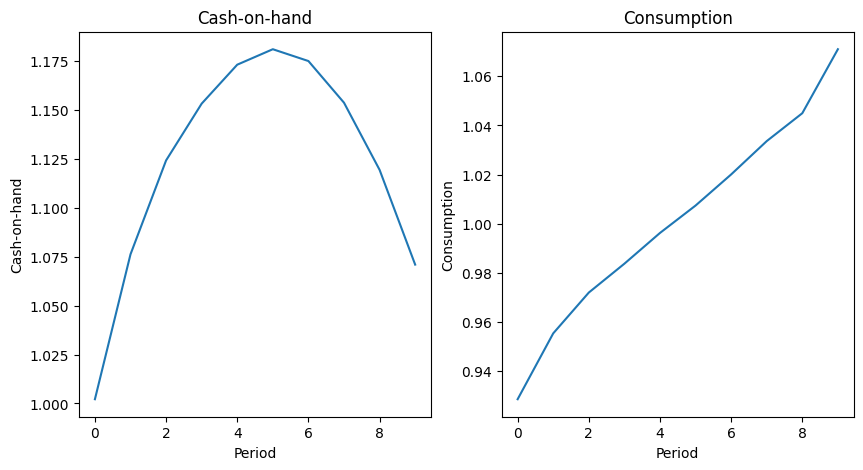

In [59]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(jnp.mean(model.sim['states'][:, :, 0], axis=1), label='Cash-on-hand')
ax[0].set_title('Cash-on-hand')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Cash-on-hand')

ax[1].plot(jnp.mean(model.sim['outcomes'][:, :, 0], axis=1), label='consumption')
ax[1].set_title('Consumption')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Consumption')

## 9. Consumption function

In [61]:
p_mean = model.sim['states'][..., 1].mean()

m_grid = np.linspace(1.0, 1.5, 100)
c_func = np.zeros((model.par['T'], 100))

for i_t, t in enumerate(range(model.par['T'])):
    for i_m, m in enumerate(m_grid):
        states = jnp.array([[m, p_mean]])
        c_func[i_t, i_m] = eval_policy(model.Policy, states, t)[0,0]

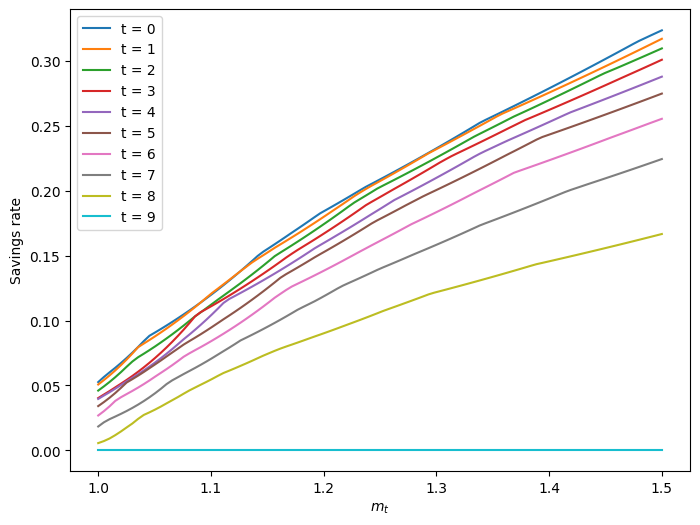

In [69]:
f, ax = plt.subplots(figsize=(8,6))
for t in range(model.par['T']): ax.plot(m_grid, c_func[t], label=f't = {t}')
ax.set_xlabel('$m_t$')
ax.set_ylabel('Savings rate')
ax.legend()

## 10. Test speed

In [76]:
base_T = 20
base_N = 5000
K = 10_000

dif_T = [(base_N, t) for t in [5, 10, 20, 40, 60]]
dif_N = [(n, base_T) for n in [500, 1000, 2000, 5000, 10_000]]

difs = dif_T + dif_N